<a href="https://colab.research.google.com/github/udlbook/udlbook/blob/main/Notebooks/Chap03/3_2_Shallow_Networks_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Notebook 3.2 -- Shallow neural networks II**

The purpose of this notebook is to gain some familiarity with shallow neural networks with 2D inputs.  It works through an example similar to figure 3.8 and experiments with different activation functions. <br><br>

Work through the cells below, running each cell in turn. In various places you will see the words "TO DO". Follow the instructions at these places and write code to complete the functions. There are also questions interspersed in the text.

Contact me at udlbookmail@gmail.com if you find any mistakes or have any suggestions.


In [1]:
# import a bunch of mojo things to help with math computation

from benchmark import Unit, run
from math import iota
from math import ceil
from math import select
from math import pow
from python import Python
from python.object import PythonObject
from python import Dictionary
from runtime.llcl import num_cores
from algorithm import parallelize, vectorize, vectorize_unroll
from tensor import Tensor, TensorShape, TensorSpec
from utils.index import Index

alias float_type = DType.float32
alias simd_width = simdwidthof[float_type]()

In [2]:
%%python
# Imports math library
# import numpy as np
# Imports plotting library
# import matplotlib.pyplot as plt

from importlib.util import find_spec
import shutil
import subprocess

fix = """
-------------------------------------------------------------------------
fix following the steps here:
    https://github.com/modularml/mojo/issues/1085#issuecomment-1771403719
-------------------------------------------------------------------------
"""

def install_if_missing(name: str):
    if find_spec(name):
        return

    print(f"{name} not found, installing...")
    try:
        if shutil.which('python3'): python = "python3"
        elif shutil.which('python'): python = "python"
        else: raise ("python not on path" + fix)
        subprocess.check_call([python, "-m", "pip", "install", name])
    except:
        raise ImportError(f"{name} not found" + fix)

install_if_missing("numpy")
install_if_missing("matplotlib")

In [89]:
# define a meshgrid function that takes two 1D vectors and returns a 2D vector
fn meshgrid[T: DType](x: Tensor[T], y: Tensor[T]) -> Tensor[T]:
    let xlen = Int(x.shape()[0])
    let ylen = Int(y.shape()[0])
    let spec = TensorSpec(T, 2, ylen, xlen)
    var grid = Tensor[T](spec)
    for i in range(ylen):
        for j in range(xlen):
            grid[Index(0,i,j)] = x[j]
            grid[Index(1,i,j)] = y[i]
    return grid

fn meshgrid_x[T: DType](x: Tensor[T], y: Tensor[T]) -> Tensor[T]:
    let xlen = Int(x.shape()[0])
    let ylen = Int(y.shape()[0])
    let spec = TensorSpec(T, ylen, xlen)
    var grid = Tensor[T](spec)
    for i in range(ylen):
        for j in range(xlen):
            grid[Index(i,j)] = x[j]
    return grid

fn meshgrid_y[T: DType](x: Tensor[T], y: Tensor[T]) -> Tensor[T]:
    let xlen = Int(x.shape()[0])
    let ylen = Int(y.shape()[0])
    let spec = TensorSpec(T, ylen, xlen)
    var grid = Tensor[T](spec)
    for i in range(ylen):
        for j in range(xlen):
            grid[Index(i,j)] = y[i]
    return grid


fn mesh2np[T: DType](borrowed mesh: Tensor[T]) raises -> Dictionary:
    let np = Python.import_module("numpy")
    let xlen = mesh.shape()[2]
    let ylen = mesh.shape()[1]
    let x_grid = np.zeros((ylen, xlen)) #strange how mojo doesn't understand mutability here
    let y_grid = np.zeros((ylen, xlen))
    for i in range(ylen):
        for j in range(xlen):
            x_grid.itemset((i,j), mesh[0, i, j])
            y_grid.itemset((i,j), mesh[1, i, j])

    let xy = Python.dict()
    xy["x"] = x_grid
    xy["y"] = y_grid

    return xy
            

let x = Tensor[float_type](TensorShape(3), 1, 3, 5)
let y = Tensor[float_type](TensorShape(3), -2, -4, -6)
let grid = meshgrid(x,y)
print(grid)
let grids: Dictionary = mesh2np[float_type](grid)
print(grids["x"])
print(grids["y"])

            x_grid.itemset((i,j), mesh[0, i, j])
            ~~~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~
            _ = 

            y_grid.itemset((i,j), mesh[1, i, j])
            ~~~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~
            _ = 



Tensor([[[1.0, 3.0, 5.0],
[1.0, 3.0, 5.0],
[1.0, 3.0, 5.0]],
[[-2.0, -2.0, -2.0],
[-4.0, -4.0, -4.0],
[-6.0, -6.0, -6.0]]], dtype=float32, shape=2x3x3)
[[1. 3. 5.]
 [1. 3. 5.]
 [1. 3. 5.]]
[[-2. -2. -2.]
 [-4. -4. -4.]
 [-6. -6. -6.]]


In [8]:
# Code to draw 2D function
def draw_2D_function(ax: PythonObject, x1_mesh: PythonObject, x2_mesh: PythonObject, y: PythonObject):

    # import the required python modules
    let np = Python.import_module("numpy")
    let plt = Python.import_module("matplotlib.pyplot")
    let colors = Python.import_module("matplotlib.colors")

    pos = ax.contourf(x1_mesh, x2_mesh, y) #, levels=256 ,cmap = 'hot', vmin=-10,vmax=10.0)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    levels = np.arange(-10,10,1.0)
    ax.contour(x1_mesh, x2_mesh, y, levels)

In [98]:
# Plot the shallow neural network.  We'll assume input in is range [0,10],[0,10] and output [-10,10]
def plot_neural_2_inputs(packed: Dictionary):
    # x1, x2, y, pre_1, pre_2, pre_3, act_1, act_2, act_3, w_act_1, w_act_2, w_act_3):

    # import the required python modules
    let np = Python.import_module("numpy")
    let plt = Python.import_module("matplotlib.pyplot")
    let colors = Python.import_module("matplotlib.colors")

    print(1)
    fig_ax = plt.subplots(3,3)
    
    fig = fig_ax[0]
    ax = fig_ax[1]
    fig.set_visible(False)

    print(2)
    #fig.set_size_inches(8.5, 8.5)
    fig.tight_layout() # pad=3.0

    print(3)
    draw_2D_function(ax.item((0,0)), packed["x1"], packed["x2"], packed["pre_1"])
    print(3)
    ax.item((0,0)).set_title('Preactivation')
    print(3)
    draw_2D_function(ax.item((0,1)), packed["x1"], packed["x2"], packed["pre_2"]); ax.item((0,1)).set_title('Preactivation')
    draw_2D_function(ax.item((0,2)), packed["x1"], packed["x2"], packed["pre_3"]); ax.item((0,2)).set_title('Preactivation')
    draw_2D_function(ax.item((1,0)), packed["x1"], packed["x2"], packed["act_1"]); ax.item((1,0)).set_title('Activation')
    draw_2D_function(ax.item((1,1)), packed["x1"], packed["x2"], packed["act_2"]); ax.item((1,1)).set_title('Activation')
    draw_2D_function(ax.item((1,2)), packed["x1"], packed["x2"], packed["act_3"]); ax.item((1,2)).set_title('Activation')
    draw_2D_function(ax.item((2,0)), packed["x1"], packed["x2"], packed["w_act_1"]); ax.item((2,0)).set_title('Weighted Act')
    draw_2D_function(ax.item((2,1)), packed["x1"], packed["x2"], packed["w_act_2"]); ax.item((2,1)).set_title('Weighted Act')
    draw_2D_function(ax.item((2,2)), packed["x1"], packed["x2"], packed["w_act_3"]); ax.item((2,2)).set_title('Weighted Act')

    print(4)
    fig.set_visible(True)
    plt.show()

    print(5)
    fig_ax = plt.subplots()
    fig = fig_ax[0]
    ax = fig_ax[1]

    print(6)
    draw_2D_function(ax, packed["x1"], packed["x2"], packed["y"])
    ax.set_title('Network output, $y$')
    ax.set_aspect(1.0)
    plt.show()

In [99]:
# Define the Rectified Linear Unit (ReLU) function
fn ReLU[T: DType, width: Int](preactivation: SIMD[T, width]) -> SIMD[T, width]:
    let is_zero = preactivation < 0
    let zeros = SIMD[T, width]()
    return select(is_zero, zeros, preactivation)

fn ReLU[T: DType, width: Int](preactivation: Tensor[T]) -> Tensor[T]:
    let original_shape = preactivation.shape()
    let num_elements = preactivation.num_elements()
    let data = preactivation.data()

    var relu = Tensor[T](original_shape)
    var relu_data = relu.data()

    @parameter
    fn compute[width: Int](col: Int):
        let y = ReLU[T, width](data.simd_load[width](col))
        relu_data.simd_store[width](col, y)
    
    vectorize[width, compute](num_elements)
    return relu

In [100]:
let z = SIMD[float_type, simd_width](-5, 5, 0, -2)
print(ReLU(z))

let z1 = Tensor[float_type](TensorShape(3,4), 0, 1, 2, 3, 4, 5, 6, -1, -2, -3, -4, -5)
print(ReLU[float_type, simd_width](z1))

[0.0, 5.0, 0.0, 0.0]
Tensor([[0.0, 1.0, 2.0, 3.0],
[4.0, 5.0, 6.0, 0.0],
[0.0, 0.0, 0.0, 0.0]], dtype=float32, shape=3x4)


In [101]:
fn tensor2np[T: DType](borrowed tensor: Tensor[T]) raises -> PythonObject:
    let np = Python.import_module("numpy")
    let shape = tensor.shape()
    let ysize = shape[0]
    let xsize = shape[1]
    let xnp = np.zeros((ysize, xsize))
    for j in range(ysize):
        for i in range(xsize):
            xnp.itemset((j,i), tensor[j,i])
    return xnp

# Define a shallow neural network with two inputs, one output, and three hidden units
fn shallow_2_1_3[T: DType, width: Int](
                    borrowed x1: Tensor[T], borrowed x2: Tensor[T], 
                  phi_0: SIMD[T,1], phi_1: SIMD[T,1], phi_2: SIMD[T,1], phi_3: SIMD[T,1], 
                  theta_10: SIMD[T,1], theta_11: SIMD[T,1], theta_12: SIMD[T,1],
                  theta_20: SIMD[T,1], theta_21: SIMD[T,1], theta_22: SIMD[T,1],
                  theta_30: SIMD[T,1], theta_31: SIMD[T,1], theta_32: SIMD[T,1]) raises -> Dictionary:

    # TODO Replace the lines below to compute the three initial linear functions
    # (figure 3.8a-c) from the theta parameters.  These are the preactivations
    let pre_1 = theta_10 + theta_11 * x1 + theta_12 * x2
    let pre_2 = theta_20 + theta_21 * x1 + theta_22 * x2
    let pre_3 = theta_30 + theta_31 * x1 + theta_32 * x2

    # Pass these through the ReLU function to compute the activations as in
    # figure 3.8 d-f
    let act_1 = ReLU[T, width](pre_1)
    let act_2 = ReLU[T, width](pre_2)
    let act_3 = ReLU[T, width](pre_3)

    # TODO Replace the code below to weight the activations using phi1, phi2 and phi3
    # To create the equivalent of figure 3.8 g-i
    let w_act_1 = phi_1 * act_1
    let w_act_2 = phi_2 * act_2
    let w_act_3 = phi_3 * act_3

    # TODO Replace the code below to combing the weighted activations and add
    # phi_0 to create the output as in figure 3.8j
    let y = phi_0 + phi_1*w_act_1 + phi_2*w_act_2 + phi_3*w_act_3

    # Return everything we have calculated
    let packed = Python.dict()
    packed["x1"] = tensor2np(x1)
    packed["x2"] = tensor2np(x2)
    packed["y"] = tensor2np(y)
    packed["pre_1"] = tensor2np(pre_1)
    packed["pre_2"] = tensor2np(pre_2)
    packed["pre_3"] = tensor2np(pre_3)
    packed["act_1"] = tensor2np(act_1)
    packed["act_2"] = tensor2np(act_2)
    packed["act_3"] = tensor2np(act_3)
    packed["w_act_1"] = tensor2np(w_act_1)
    packed["w_act_2"] = tensor2np(w_act_2)
    packed["w_act_3"] = tensor2np(w_act_3)

    return packed

            xnp.itemset((j,i), tensor[j,i])
            ~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~
            _ = 



In [102]:
# Linear init function
fn linear_init[T: DType](start: SIMD[T,1] = 0, end: SIMD[T,1] = 1, step: SIMD[T,1] = 1) -> Tensor[T]:
    from math import ceil
    let length = ceil((end-start)/step).to_int()
    var t = Tensor[T](length)
    var v = start
    for i in range(length):
        t[i] = v
        v = v + step

    return t

In [103]:
# Now let's define some parameters and run the neural network
let theta_10 =  -4.0
let theta_11 = 0.9
let theta_12 = 0.0
let theta_20 =  5.0
let theta_21 = -0.9
let theta_22 = -0.5
let theta_30 =  -7
let theta_31 = 0.5
let theta_32 = 0.9
let phi_0 = 0.0
let phi_1 = -2.0
let phi_2 = 2.0
let phi_3 = 1.5

let x1 = linear_init[float_type](0.0, 10.0, 0.1)
let x2 = linear_init[float_type](0.0, 10.0, 0.1)
x1_m = meshgrid_x(x1, x2)
x2_m = meshgrid_y(x1, x2)

# We run the neural network for each of these input values
let packed = shallow_2_1_3[float_type, simd_width](
                    x1_m, x2_m,
                    phi_0, phi_1, phi_2, phi_3,
                    theta_10, theta_11, theta_12, 
                    theta_20, theta_21, theta_22, 
                    theta_30, theta_31, theta_32)

[[0.         0.1        0.2        ... 9.70000076 9.80000114 9.90000153]
 [0.         0.1        0.2        ... 9.70000076 9.80000114 9.90000153]
 [0.         0.1        0.2        ... 9.70000076 9.80000114 9.90000153]
 ...
 [0.         0.1        0.2        ... 9.70000076 9.80000114 9.90000153]
 [0.         0.1        0.2        ... 9.70000076 9.80000114 9.90000153]
 [0.         0.1        0.2        ... 9.70000076 9.80000114 9.90000153]]
1
2
3
3
3
4


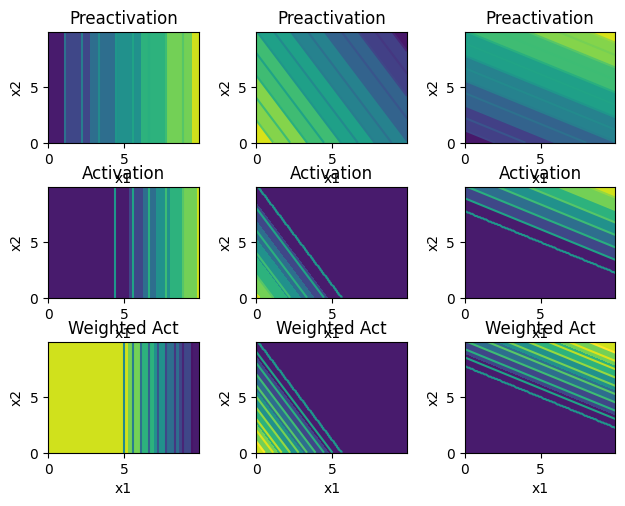


5
6


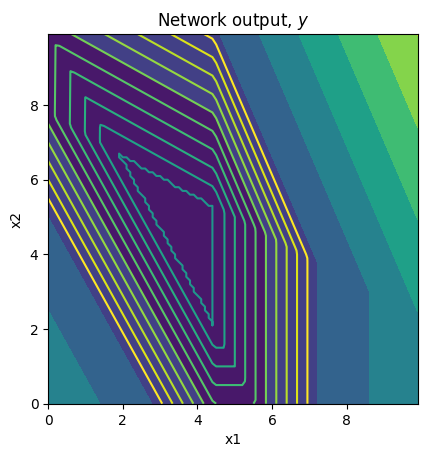

In [104]:
# And then plot it
print(packed["x1"])
plot_neural_2_inputs(packed)

How many different linear polytopes are made by this model?  Identify each in the network output.

Now we'll extend this model to have two outputs $y_1$ and $y_2$, each of which can be visualized with a separate heatmap.  You will now have sets of parameters $\phi_{10}, \phi_{11}, \phi_{12}, \phi_{13}$ and $\phi_{20}, \phi_{21}, \phi_{22}, \phi_{23}$ that correspond to each of these outputs.

In [ ]:
# Plot the shallow neural network.  We'll assume input in is range [0,10],[0,10] and output [-10,10]
def plot_neural_2_inputs_2_outputs(x1,x2, y1, y2, pre_1, pre_2, pre_3, act_1, act_2, act_3, w_act_11, w_act_12, w_act_13, w_act_21, w_act_22, w_act_23):

  # Plot intermediate plots if flag set
  fig, ax = plt.subplots(4,3)
  fig.set_size_inches(8.5, 8.5)
  fig.tight_layout(pad=3.0)
  draw_2D_function(ax[0,0], x1,x2,pre_1); ax[0,0].set_title('Preactivation')
  draw_2D_function(ax[0,1], x1,x2,pre_2); ax[0,1].set_title('Preactivation')
  draw_2D_function(ax[0,2], x1,x2,pre_3); ax[0,2].set_title('Preactivation')
  draw_2D_function(ax[1,0], x1,x2,act_1); ax[1,0].set_title('Activation')
  draw_2D_function(ax[1,1], x1,x2,act_2); ax[1,1].set_title('Activation')
  draw_2D_function(ax[1,2], x1,x2,act_3); ax[1,2].set_title('Activation')
  draw_2D_function(ax[2,0], x1,x2,w_act_11); ax[2,0].set_title('Weighted Act 1')
  draw_2D_function(ax[2,1], x1,x2,w_act_12); ax[2,1].set_title('Weighted Act 1')
  draw_2D_function(ax[2,2], x1,x2,w_act_13); ax[2,2].set_title('Weighted Act 1')
  draw_2D_function(ax[3,0], x1,x2,w_act_21); ax[3,0].set_title('Weighted Act 2')
  draw_2D_function(ax[3,1], x1,x2,w_act_22); ax[3,1].set_title('Weighted Act 2')
  draw_2D_function(ax[3,2], x1,x2,w_act_23); ax[3,2].set_title('Weighted Act 2')
  plt.show()

  fig, ax = plt.subplots()
  draw_2D_function(ax,x1,x2,y1)
  ax.set_title('Network output, $y_1$')
  ax.set_aspect(1.0)
  plt.show()

  fig, ax = plt.subplots()
  draw_2D_function(ax,x1,x2,y2)
  ax.set_title('Network output, $y_2$')
  ax.set_aspect(1.0)
  plt.show()

In [ ]:

# Define a shallow neural network with, two inputs, two outputs, and three hidden units
def shallow_2_2_3(x1,x2, activation_fn, phi_10,phi_11,phi_12,phi_13, phi_20,phi_21,phi_22,phi_23, theta_10, theta_11,\
                  theta_12, theta_20, theta_21, theta_22, theta_30, theta_31, theta_32):

  # TODO -- write this function -- replace the dummy code below
  pre_1 = np.zeros_like(x1)
  pre_2 = np.zeros_like(x1)
  pre_3 = np.zeros_like(x1)
  act_1 = np.zeros_like(x1)
  act_2 = np.zeros_like(x1)
  act_3 = np.zeros_like(x1)
  w_act_11 = np.zeros_like(x1)
  w_act_12 = np.zeros_like(x1)
  w_act_13 = np.zeros_like(x1)
  w_act_21 = np.zeros_like(x1)
  w_act_22 = np.zeros_like(x1)
  w_act_23 = np.zeros_like(x1)
  y1 = np.zeros_like(x1)
  y2 = np.zeros_like(x1)


  # Return everything we have calculated
  return y1,y2, pre_1, pre_2, pre_3, act_1, act_2, act_3, w_act_11, w_act_12, w_act_13, w_act_21, w_act_22, w_act_23


In [ ]:
# Now lets define some parameters and run the neural network
theta_10 =  -4.0 ;  theta_11 = 0.9; theta_12 = 0.0
theta_20 =  5.0  ; theta_21 = -0.9 ; theta_22 = -0.5
theta_30 =  -7  ; theta_31 = 0.5; theta_32 = 0.9
phi_10 = 0.0; phi_11 = -2.0; phi_12 = 2.0; phi_13 = 1.5
phi_20 = -2.0; phi_21 = -1.0; phi_22 = -2.0; phi_23 = 0.8

x1 = np.arange(0.0, 10.0, 0.1)
x2 = np.arange(0.0, 10.0, 0.1)
x1,x2 = np.meshgrid(x1,x2)  # https://www.geeksforgeeks.org/numpy-meshgrid-function/

# We run the neural network for each of these input values
y1, y2, pre_1, pre_2, pre_3, act_1, act_2, act_3, w_act_11, w_act_12, w_act_13, w_act_21, w_act_22, w_act_23 = \
    shallow_2_2_3(x1,x2, ReLU, phi_10,phi_11,phi_12,phi_13, phi_20,phi_21,phi_22,phi_23, theta_10, theta_11, theta_12, theta_20, theta_21, theta_22, theta_30, theta_31, theta_32)
# And then plot it
plot_neural_2_inputs_2_outputs(x1,x2, y1, y2, pre_1, pre_2, pre_3, act_1, act_2, act_3, w_act_11, w_act_12, w_act_13, w_act_21, w_act_22, w_act_23)